<a href="https://colab.research.google.com/github/oailnivek/ML100-Days/blob/master/homework/Day_088_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [0]:
import os
import keras

os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [0]:
train, test = keras.datasets.cifar10.load_data()

In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization

def build_mlp(input_shape=x_train.shape[1:], output_units=10, num_neurons=[256, 256, 256]):
    input = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        layer = Dense(units=n_units, activation='relu')
        x = layer(input if i == 0 else x)
        x = BatchNormalization()(x)
        
    out = Dense(units=output_units, activation='softmax')(x)
    
    return Model(inputs=[input], outputs=[out])

def model_summary():
    model = build_mlp()
    model.summary()
    
model_summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
batc

In [0]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [0]:
# 載入 Callbacks
from keras.callbacks import Callback

# Record_fp_tp
class Record_tp_tn(Callback):
    def on_train_begin(self, epoch, logs={}):
        logs = logs or {}
        record_items = ['val_tpZ', 'val_tn']
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)

    def on_epoch_end(self, epoch, logs={}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis=1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        logs['val_tp'] = sum(y_true * y_pred)
        logs['val_tn'] = sum((y_true == 0) & (y_pred == 0))


rec_tptn = Record_tp_tn()

In [15]:
model = build_mlp()
# model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""
To do:
Fit the model with rec_tptn callback_fn
"""
model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, y_test),
    shuffle=True,
    callbacks=[rec_tptn]
)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

"""
To do:
Collect tp/tn from model history
"""
valid_tp = model.history.history['val_tp']
valid_tn = model.history.history['val_tn']

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 130us/step - loss: 2.2442 - acc: 0.2682 - val_loss: 2.2343 - val_acc: 0.2974
Epoch 2/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.7651 - acc: 0.3852 - val_loss: 1.8600 - val_acc: 0.3731
Epoch 3/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.6327 - acc: 0.4300 - val_loss: 1.7138 - val_acc: 0.4053
Epoch 4/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.5573 - acc: 0.4558 - val_loss: 1.6541 - val_acc: 0.4296
Epoch 5/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.5045 - acc: 0.4732 - val_loss: 1.6068 - val_acc: 0.4364
Epoch 6/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.4606 - acc: 0.4897 - val_loss: 1.5974 - val_acc: 0.4458
Epoch 7/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.4232 - acc: 0.5031 - val_loss: 1.5462 - 

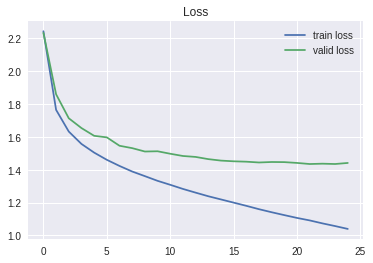

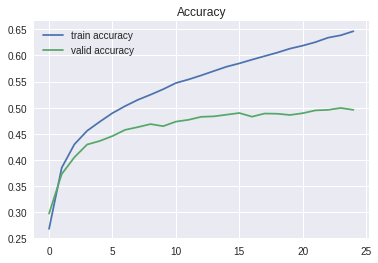

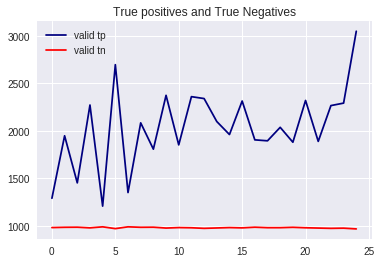

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()
